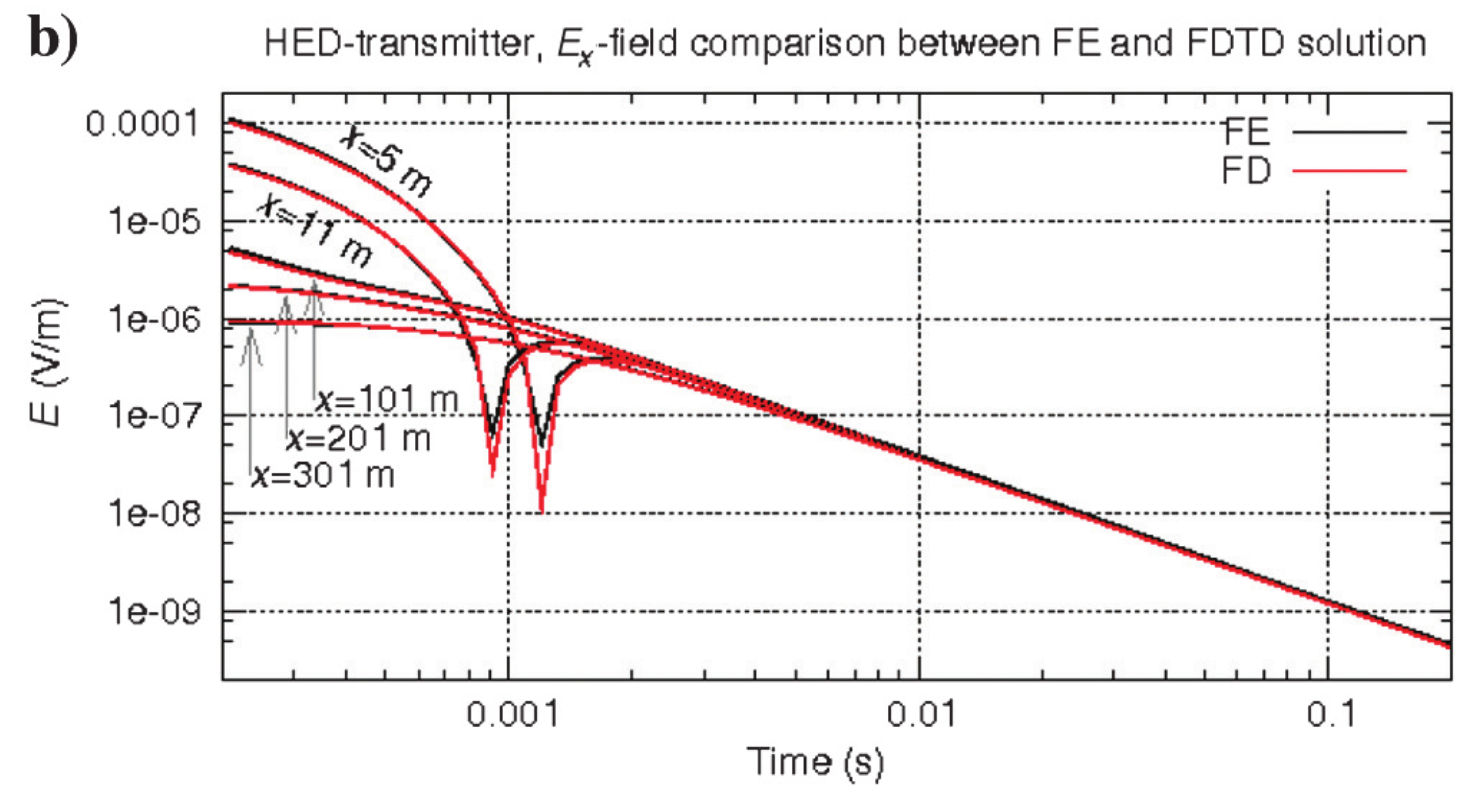

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

/Users/lindseyjh/git/python_symlinks/SimPEG/EM/Static/DC/IODC.py:13: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


In [2]:
# simDir = 'Commer_example_refine_z_t'
# simDir = 'Commer_example_1cell_across_casing'
# simDir = 'Commer_example_preserve_conductance'
# simDir = 'Commer_example_very_small_timestep'
simDir = 'Commer_example_SimPEG_updates'
# simDir = 'Commer_example_grounded_vertical_src'

In [3]:
area_commer = np.pi*((135e-3/2.)**2 - (135e-3/2. - 12.223e-3/2.)**2)

In [4]:
area_simpeg = np.pi*((135e-3/2.)**2 - (135e-3/2. - 12e-3/2.)**2)

In [5]:
# print(area_commer*sigma_casing, area_simpeg*sigma_casing)

In [6]:
# area_simpeg*sigma_casing/area_commer

In [7]:
sigma_air = 3e-4
sigma_back = 0.0333
sigma_casing = 1e6
# sigma_casing = area_simpeg*sigma_casing/area_commer

outer_diameter = 135e-3  # 135 mm outer diameter
casing_t = 12e-3  # they use 12.223 mm (should be close enough)

mur_casing = 1.

dipole_l = 10. 
casing_l = 200 

csz = 2.5 

In [21]:
src_center = np.r_[50., 1.5*np.pi, 0.] # make sure dipole is below surface
src_a = src_center + np.r_[dipole_l / 2., 0., 0.]
src_b = src_center - np.r_[dipole_l / 2., 0., 0.]

In [22]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = outer_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)

In [23]:
timeSteps = [(1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)]
# timeSteps = [
#     (3e-10, 20), 
#     (1e-9, 20), (3e-9, 20), 
#     (1e-8, 20), (3e-8, 20),
#     (1e-7, 20), (3e-7, 20),
#     (1e-6, 20), 
#     (1e-5, 30), (3e-5, 30), 
#     (1e-4, 40), (3e-4, 30), 
#     (1e-3, 20), 
#     (1e-2, 17)
# ]


model.timeSteps = timeSteps
print(model.timeSteps.sum())
print(len(model.timeSteps))

0.20422
187


In [24]:
model.diffusion_distance(2e-1)

3091.7398727827467

In [25]:
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [26]:
dipole_l/4

2.5

In [27]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = dipole_l/4, # 4 cells across the length of the dipole
    domain_x = 300.,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 15,
    npadz = 16,
    csz = csz,
#     pfz = 1.5,
)

314272


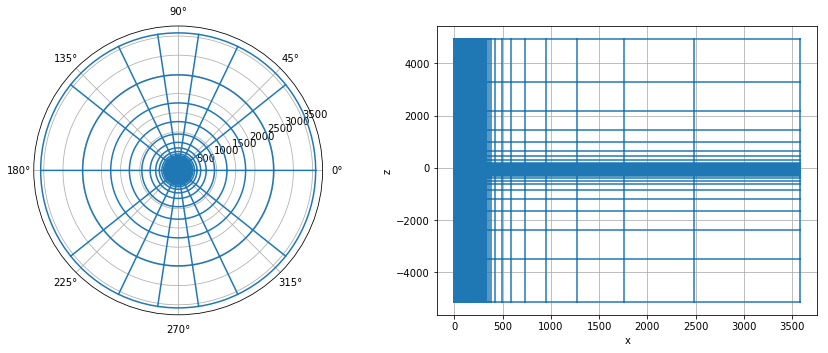

In [28]:
print(meshGen.mesh.nC)
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

In [29]:
physprops = casingSim.model.PhysicalProperties(
    modelParameters=model,
    meshGenerator=meshGen
)

In [30]:
from matplotlib.colors import LogNorm

[(-300.0, 10.0), (-300.0, 10.0)]

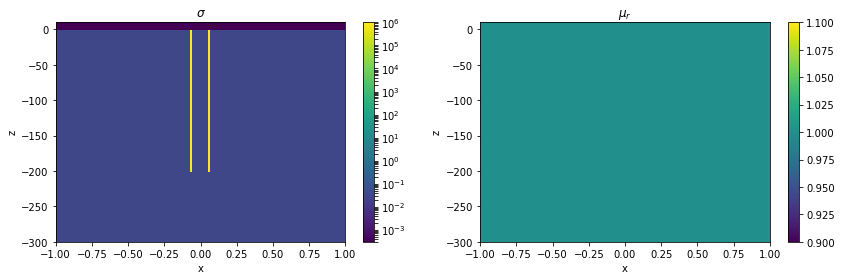

In [31]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-300., 10.]

ax = physprops.plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [32]:
src = casingSim.sources.SurfaceGroundedSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
)

# src = casingSim.sources.HorizontalElectricDipole(
#     directory=simDir, 
#     modelParameters=model, 
#     meshGenerator=meshGen,
# #     physics="TDEM"
# )

(-10.0, 10.0)

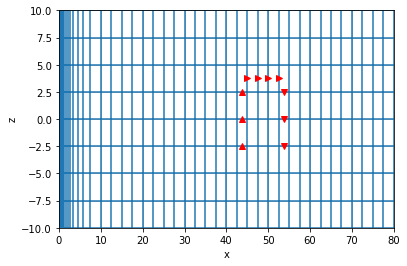

In [33]:
fig, ax = plt.subplots(1, 1)
meshGen.mesh.plotGrid(slice='theta', ax=ax)
src.plot(ax=ax)

ax.set_xlim([0., 80.])
ax.set_ylim([-10., 10.])

In [63]:
src.src_a_closest

array([53.75      ,  4.71238898, -2.5       ])

In [64]:
src.src_b_closest

array([43.75      ,  4.71238898, -2.5       ])

(0.0, 60.0)

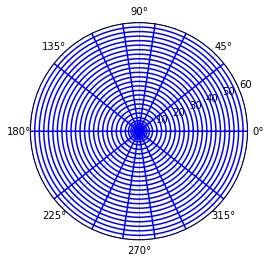

In [65]:
ax = meshGen.mesh.plotGrid(slice="z")
ax.set_rlim([0., 60.])

In [24]:
ax = meshGen.mesh.plotGrid

In [25]:
sim3D = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    src=src, 
)

In [26]:
sim3D.write_py(include2D=False, includeDC=False)

Saved Commer_example_grounded_vertical_src/ModelParameters.json
Saved Commer_example_grounded_vertical_src/MeshParameters.json
Saved Commer_example_grounded_vertical_src/Source.json
wrote Commer_example_grounded_vertical_src/simulation.py


In [30]:
# # where we are going to evaluate the fields

x_locs = np.r_[5, 11, 51, 101, 151, 201, 251, 301]
y_locs = np.r_[np.pi/2.]
z_locs = np.r_[sim3D.src.src_a[2]]
points = Utils.closestPoints(
    sim3D.meshGenerator.mesh, Utils.ndgrid(x_locs, y_locs, z_locs), 'Fx'
)

# j_compare = fields[:, 'j', :]
# e_compare = fields[:, 'e', :]

# jx_compare = j_compare[points, :]
# ex_compare = e_compare[points, :]

# np.save('jx_compare.npy', jx_compare)
# np.save('ex_compare.npy', ex_compare)


In [31]:
x_locs_SimPEG = sim3D.meshGenerator.mesh.gridFx[points, 0]
print(x_locs_SimPEG)

[  4.46418892  10.          50.         100.         150.
 200.         250.         300.        ]


# Load the results

In [5]:
import os
jx = np.load(simDir + os.path.sep + 'jx_compare.npy')
ex = np.load(simDir + os.path.sep + 'ex_compare.npy')
# x_locs = np.load(simDir + os.path.sep + 'x.npy')

In [6]:
sim = casingSim.run.SimulationTDEM(
    directory=simDir,
    modelParameters=simDir + os.path.sep + 'ModelParameters.json',
    meshGenerator=simDir + os.path.sep + 'MeshParameters.json',
    src=simDir + os.path.sep + 'Source.json',
    fields_filename=simDir + os.path.sep + 'fields.npy'
)

In [7]:
np.unique(sim.prob.timeMesh.h)

array([  1.00000000e-06,   1.00000000e-05,   3.00000000e-05,
         1.00000000e-04,   3.00000000e-04,   1.00000000e-03,
         1.00000000e-02])

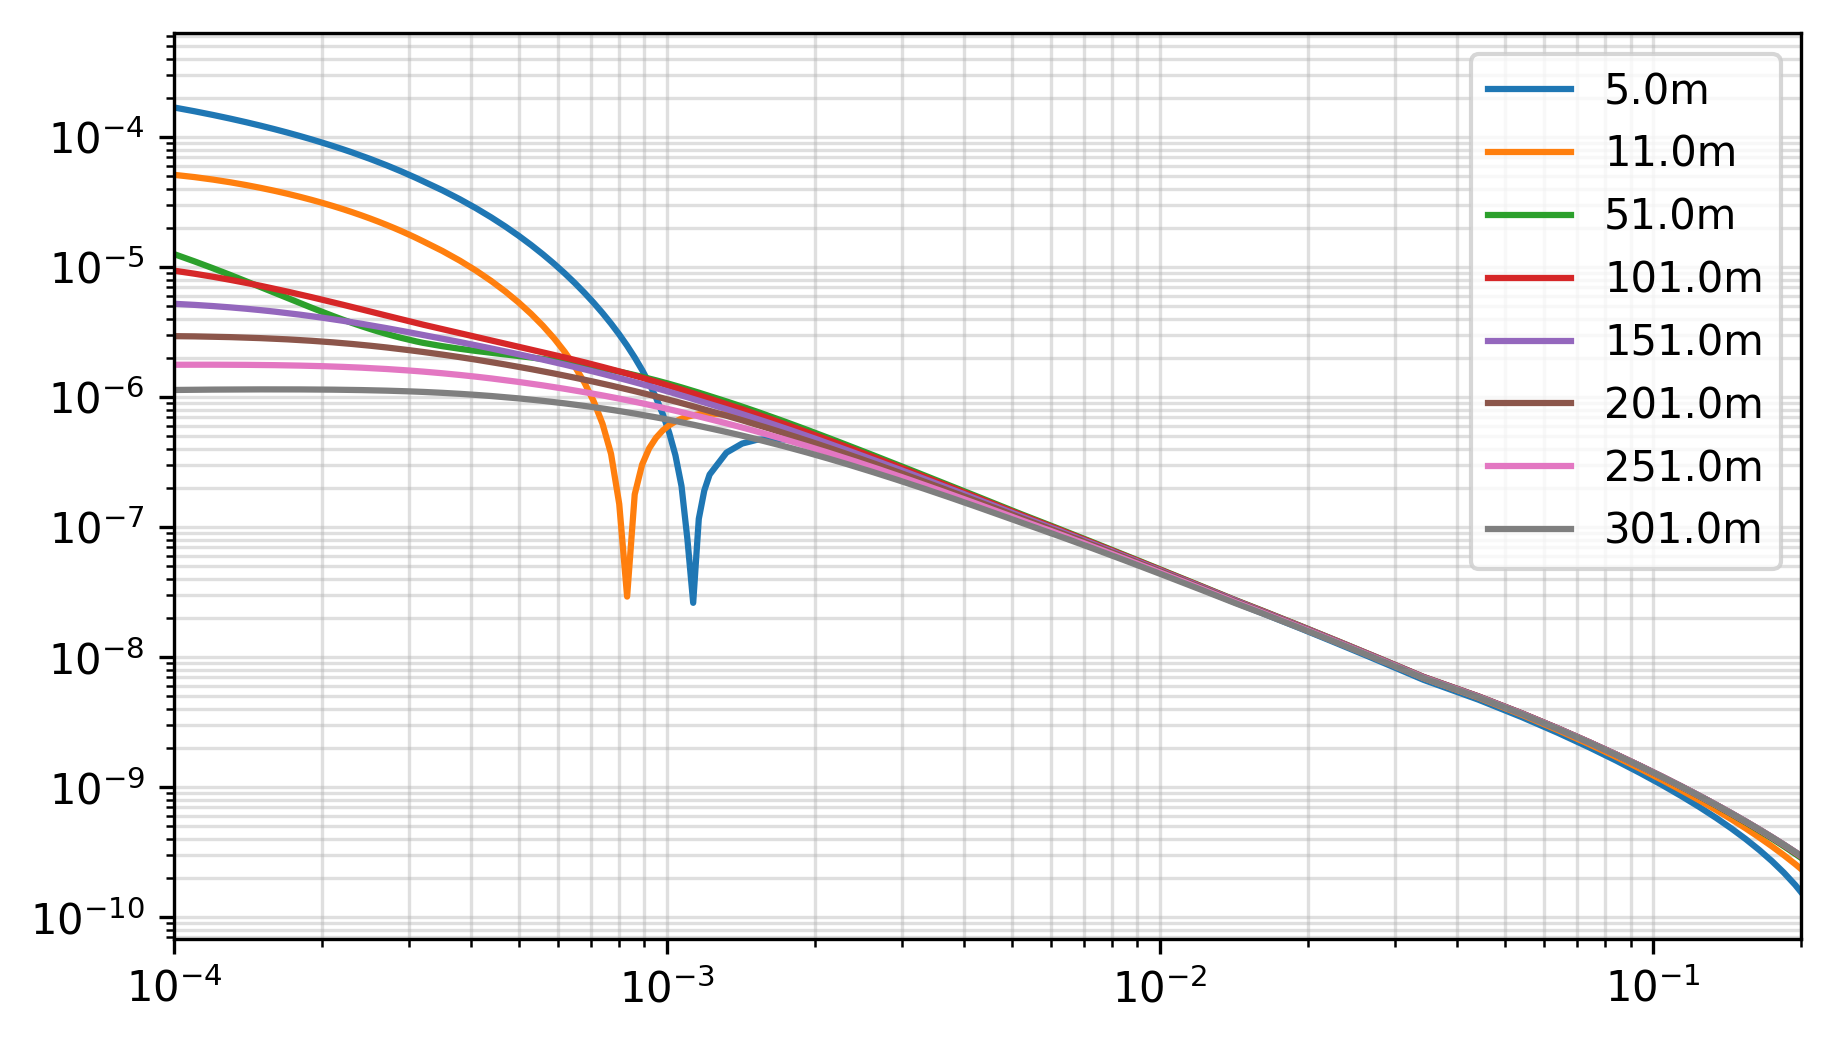

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)

for ind in range(ex.shape[0]):
    ax.loglog(sim3D.prob.times, np.abs(ex[ind, :]), label="{:1.1f}m".format(x_locs[ind]))
    ax.set_xlim(1e-4, 2e-1)
    ax.grid(which='both', alpha=0.4)
ax.legend()

# Load Commer results

In [92]:
commer_file = './CommerResults/fefd.data'

f = open(commer_file)
lines = f.readlines()
f.close()

x_locs_commer = np.r_[5, 11, 51, 101, 151, 201, 251, 301]

In [93]:
commer_data = [l.rstrip() for l in lines if not l.startswith("#") ]
commer_dat = []

dat = []
for l in commer_data:
#     print(l)
    if l != '':
        dat.append(np.array(l.split(' ')).astype(float))
    elif l == '':
        if dat != []:
            commer_dat.append(np.vstack(dat))
            dat = []

# commer_data = dat

# Load UBC results

In [94]:
ubc_filename = "ubc_135mm_1e-2.txt"
f = open(ubc_filename)
lines = f.readlines()
f.close()

In [95]:
ubc_data = [l.rstrip() for l in lines if not l.startswith("%") ]
x_locs_ubc = [4.8, 10.5, 100, 200, 300]

In [96]:
ubc_dat = []
dat = []
for l in ubc_data:
    if l != '':
        line = l.split(' ')
        line = [entry for entry in line if entry != '']
        dat.append(np.array(line).astype(float))
#         print(dat)

ubc_dat = np.vstack(dat)

# Plot Comparison

In [97]:
model.sigma_back

0.0333

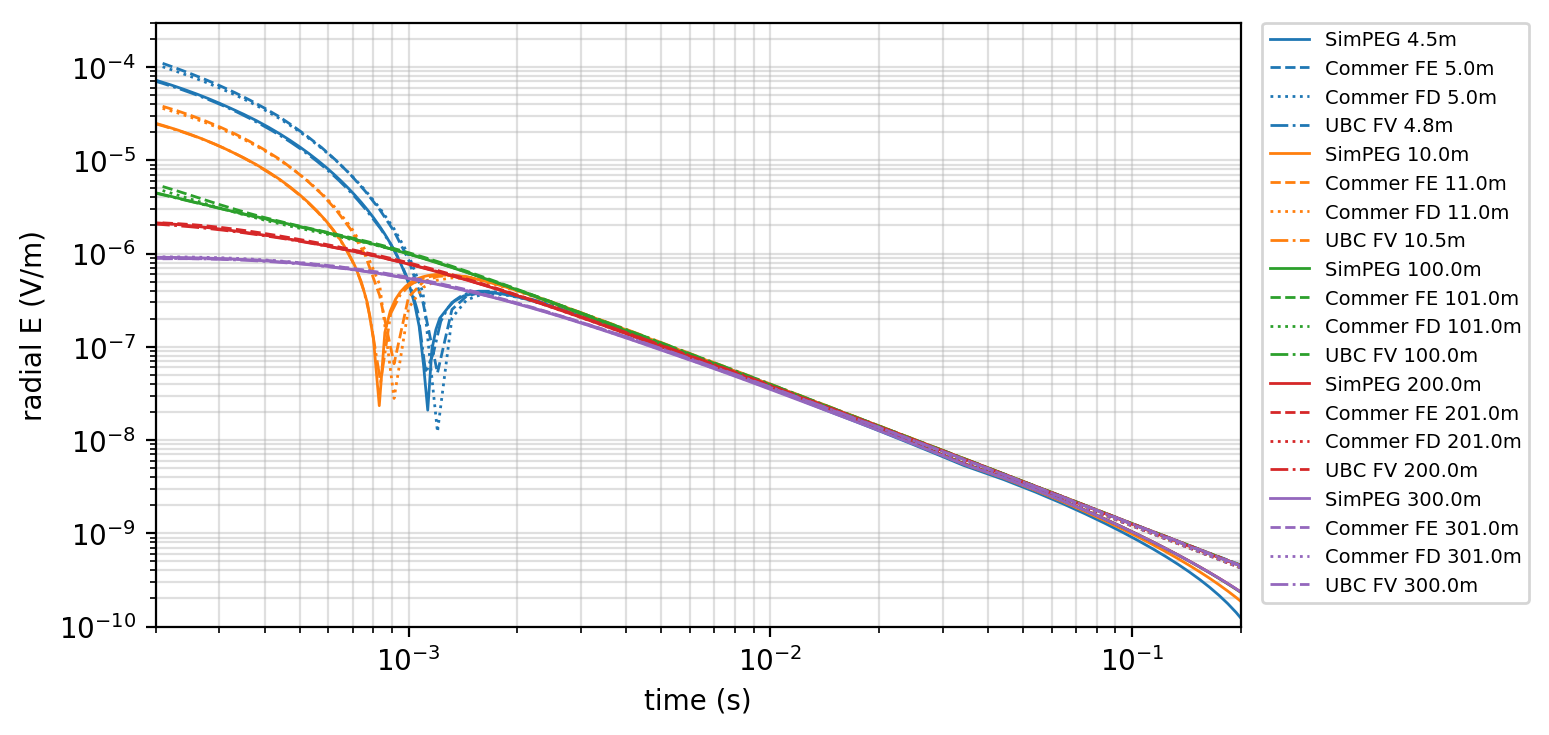

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=200)

inds_compare = [0, 1, 3, 5, 7]
for i, ind in enumerate(inds_compare):
    
    ax.loglog(
        sim3D.prob.times, np.abs(ex[ind, :])/1.25, "C{}".format(i), lw=1,
        label="SimPEG {:1.1f}m".format(x_locs_SimPEG[ind]),
    )
    ax.loglog(
        commer_dat[ind][:, 0], np.absolute(commer_dat[ind][:, 1]), "C{}--".format(i), lw=1,
        label="Commer FE {:1.1f}m".format(x_locs_commer[ind])
    )
    ax.loglog(
        commer_dat[ind][:, 0], np.absolute(commer_dat[ind][:, 2]), "C{}:".format(i), lw=1,
        label="Commer FD {:1.1f}m".format(x_locs_commer[ind])
    )
    ax.loglog(
        ubc_dat[:, 0], np.absolute(ubc_dat[:, i+1]), "C{}-.".format(i), lw=1,
        label="UBC FV {:1.1f}m".format(x_locs_ubc[i])
    )
    ax.set_xlim(2e-4, 2e-1)
    ax.set_ylim(1e-10, 3e-4)
    ax.grid(which='both', alpha=0.4)
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=7)
ax.set_xlabel('time (s)')
ax.set_ylabel('radial E (V/m)')

In [42]:
np.save?

In [ ]:
import json
json.load(
    simDir + "/modelParameters.json"
)